# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

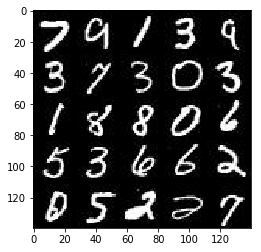

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

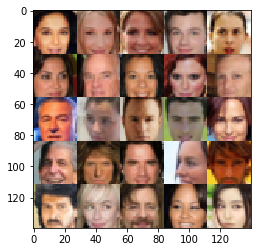

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        
        hidden_1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        leaky_relu_1 = tf.maximum(alpha * hidden_1, hidden_1)
        
        hidden_2 = tf.layers.conv2d(leaky_relu_1, 128, 5, strides=2, padding='same')
        batch_norm_2 = tf.layers.batch_normalization(hidden_2, training=True)
        leaky_relu_2 = tf.maximum(alpha * batch_norm_2, batch_norm_2)
        
        hidden_3 = tf.layers.conv2d(leaky_relu_2, 256, 5, strides=2, padding='same')
        batch_norm_3 = tf.layers.batch_normalization(hidden_3, training=True)
        leaky_relu_3 = tf.maximum(alpha * batch_norm_3, batch_norm_3)
        
        flat = tf.reshape(leaky_relu_3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2

        hidden_1 = tf.layers.dense(z, 2*2*512)
        hidden_1_r = tf.reshape(hidden_1, (-1, 2, 2, 512))
        batch_norm_1 = tf.layers.batch_normalization(hidden_1_r, training=is_train)
        leaky_relu_1 = tf.maximum(alpha * batch_norm_1, batch_norm_1)

        hidden_2 = tf.layers.conv2d_transpose(leaky_relu_1, 256, 5, 2, 'valid')
        batch_norm_2 = tf.layers.batch_normalization(hidden_2, training=is_train)
        leaky_relu_2 = tf.maximum(alpha * batch_norm_2, batch_norm_2)

        hidden_3 = tf.layers.conv2d_transpose(leaky_relu_2, 128, 5, 2, 'same')
        batch_norm_3 = tf.layers.batch_normalization(hidden_3, training=is_train)
        leaky_relu_3 = tf.maximum(alpha * batch_norm_3, batch_norm_3)

        logits = tf.layers.conv2d_transpose(leaky_relu_3, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    gen_model = generator(input_z, out_channel_dim)
    disc_model_real, disc_logits_real = discriminator(input_real)
    disc_model_fake, disc_logits_fake = discriminator(gen_model, reuse=True)

    disc_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_real, labels=tf.ones_like(disc_model_real)))
    disc_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake, labels=tf.zeros_like(disc_model_fake)))
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake, labels=tf.ones_like(disc_model_fake)))

    disc_loss = disc_loss_real + disc_loss_fake

    return disc_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    # train on the losses
    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt  


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    num_samples, img_w, img_h, img_c = data_shape
    
    real_in, z_in, lr = model_inputs(img_w, img_h, img_c, z_dim)
    
    disc_loss, gen_loss = model_loss(real_in, z_in, img_c)
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    loss = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2.0
                steps += 1

                z_batch = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(disc_opt, feed_dict={real_in: batch_images, z_in: z_batch, lr: learning_rate})
                _ = sess.run(gen_opt, feed_dict={z_in: z_batch, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_disc = disc_loss.eval({z_in: z_batch, real_in: batch_images})
                    train_loss_gen = gen_loss.eval({z_in: z_batch})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_disc),
                          "Generator Loss: {:.4f}".format(train_loss_gen))
                    loss.append((train_loss_disc, train_loss_gen))
                
                if steps % show_every == 0:
                    show_generator_output(sess, 20, z_in, img_c, data_image_mode)


                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1233... Generator Loss: 15.4271
Epoch 1/2... Discriminator Loss: 0.2677... Generator Loss: 18.8772
Epoch 1/2... Discriminator Loss: 3.8246... Generator Loss: 0.2895
Epoch 1/2... Discriminator Loss: 0.2733... Generator Loss: 1.8831
Epoch 1/2... Discriminator Loss: 0.5174... Generator Loss: 5.3899
Epoch 1/2... Discriminator Loss: 0.6181... Generator Loss: 2.1672
Epoch 1/2... Discriminator Loss: 2.6752... Generator Loss: 0.2803
Epoch 1/2... Discriminator Loss: 0.5204... Generator Loss: 1.7758
Epoch 1/2... Discriminator Loss: 0.0824... Generator Loss: 4.3886
Epoch 1/2... Discriminator Loss: 0.5646... Generator Loss: 3.6325


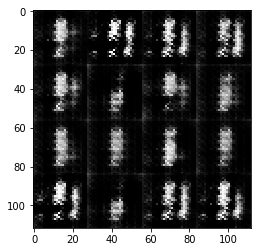

Epoch 1/2... Discriminator Loss: 0.1128... Generator Loss: 3.6309
Epoch 1/2... Discriminator Loss: 4.0687... Generator Loss: 13.9355
Epoch 1/2... Discriminator Loss: 0.1546... Generator Loss: 3.4678
Epoch 1/2... Discriminator Loss: 0.2818... Generator Loss: 1.8924
Epoch 1/2... Discriminator Loss: 0.1387... Generator Loss: 3.4674
Epoch 1/2... Discriminator Loss: 0.3965... Generator Loss: 1.8941
Epoch 1/2... Discriminator Loss: 0.3384... Generator Loss: 4.6303
Epoch 1/2... Discriminator Loss: 0.3485... Generator Loss: 2.7732
Epoch 1/2... Discriminator Loss: 0.8071... Generator Loss: 1.3666
Epoch 1/2... Discriminator Loss: 0.2329... Generator Loss: 2.5006


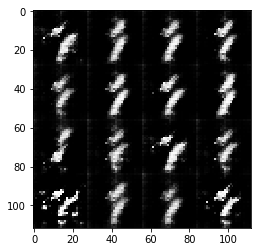

Epoch 1/2... Discriminator Loss: 0.3913... Generator Loss: 4.1098
Epoch 1/2... Discriminator Loss: 0.2385... Generator Loss: 3.1449
Epoch 1/2... Discriminator Loss: 0.1904... Generator Loss: 5.0450
Epoch 1/2... Discriminator Loss: 0.3975... Generator Loss: 2.3856
Epoch 1/2... Discriminator Loss: 0.2563... Generator Loss: 2.5773
Epoch 1/2... Discriminator Loss: 0.3390... Generator Loss: 3.5403
Epoch 1/2... Discriminator Loss: 0.1855... Generator Loss: 3.6247
Epoch 1/2... Discriminator Loss: 0.4229... Generator Loss: 3.0480
Epoch 1/2... Discriminator Loss: 0.2795... Generator Loss: 2.5310
Epoch 1/2... Discriminator Loss: 0.2456... Generator Loss: 3.4362


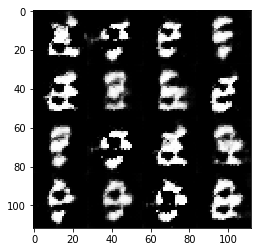

Epoch 1/2... Discriminator Loss: 0.2806... Generator Loss: 2.4178
Epoch 1/2... Discriminator Loss: 0.6632... Generator Loss: 4.5011
Epoch 1/2... Discriminator Loss: 0.3225... Generator Loss: 2.4399
Epoch 1/2... Discriminator Loss: 0.6007... Generator Loss: 1.4448
Epoch 1/2... Discriminator Loss: 0.4248... Generator Loss: 1.9226
Epoch 1/2... Discriminator Loss: 0.3228... Generator Loss: 2.0942
Epoch 1/2... Discriminator Loss: 0.5963... Generator Loss: 1.3434
Epoch 1/2... Discriminator Loss: 0.6824... Generator Loss: 1.6438
Epoch 1/2... Discriminator Loss: 0.3530... Generator Loss: 2.1803
Epoch 1/2... Discriminator Loss: 1.2315... Generator Loss: 0.5667


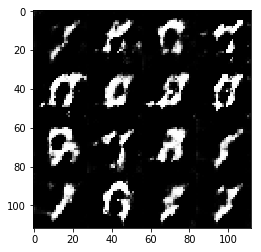

Epoch 1/2... Discriminator Loss: 0.4318... Generator Loss: 1.9405
Epoch 1/2... Discriminator Loss: 0.9144... Generator Loss: 0.8880
Epoch 1/2... Discriminator Loss: 0.6334... Generator Loss: 2.1444
Epoch 1/2... Discriminator Loss: 0.9799... Generator Loss: 1.0295
Epoch 1/2... Discriminator Loss: 0.6333... Generator Loss: 2.3553
Epoch 1/2... Discriminator Loss: 1.0309... Generator Loss: 0.7979
Epoch 2/2... Discriminator Loss: 0.8508... Generator Loss: 1.1487
Epoch 2/2... Discriminator Loss: 0.5152... Generator Loss: 1.9586
Epoch 2/2... Discriminator Loss: 0.6614... Generator Loss: 1.6930
Epoch 2/2... Discriminator Loss: 0.7848... Generator Loss: 1.0924


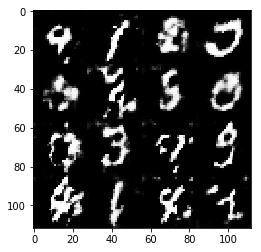

Epoch 2/2... Discriminator Loss: 0.6170... Generator Loss: 2.0799
Epoch 2/2... Discriminator Loss: 0.7316... Generator Loss: 1.2076
Epoch 2/2... Discriminator Loss: 0.6369... Generator Loss: 1.2667
Epoch 2/2... Discriminator Loss: 0.8543... Generator Loss: 1.8850
Epoch 2/2... Discriminator Loss: 0.8428... Generator Loss: 0.9309
Epoch 2/2... Discriminator Loss: 1.0587... Generator Loss: 1.0326
Epoch 2/2... Discriminator Loss: 0.8255... Generator Loss: 2.2992
Epoch 2/2... Discriminator Loss: 0.5739... Generator Loss: 1.6286
Epoch 2/2... Discriminator Loss: 0.8437... Generator Loss: 0.9789
Epoch 2/2... Discriminator Loss: 0.7441... Generator Loss: 2.6453


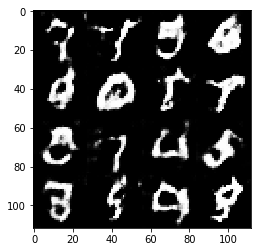

Epoch 2/2... Discriminator Loss: 0.7020... Generator Loss: 1.1282
Epoch 2/2... Discriminator Loss: 0.9055... Generator Loss: 3.1164
Epoch 2/2... Discriminator Loss: 0.6631... Generator Loss: 2.0838
Epoch 2/2... Discriminator Loss: 1.0526... Generator Loss: 0.7752
Epoch 2/2... Discriminator Loss: 0.5775... Generator Loss: 1.7776
Epoch 2/2... Discriminator Loss: 0.6150... Generator Loss: 1.6176
Epoch 2/2... Discriminator Loss: 0.9603... Generator Loss: 3.5461
Epoch 2/2... Discriminator Loss: 1.4762... Generator Loss: 3.4704
Epoch 2/2... Discriminator Loss: 0.5667... Generator Loss: 2.0611
Epoch 2/2... Discriminator Loss: 0.9824... Generator Loss: 0.8538


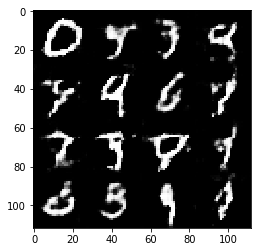

Epoch 2/2... Discriminator Loss: 1.1782... Generator Loss: 0.5271
Epoch 2/2... Discriminator Loss: 0.7030... Generator Loss: 1.1840
Epoch 2/2... Discriminator Loss: 0.6250... Generator Loss: 1.9707
Epoch 2/2... Discriminator Loss: 0.6674... Generator Loss: 1.5729
Epoch 2/2... Discriminator Loss: 0.9939... Generator Loss: 0.7434
Epoch 2/2... Discriminator Loss: 1.9338... Generator Loss: 0.2746
Epoch 2/2... Discriminator Loss: 1.4201... Generator Loss: 0.4860
Epoch 2/2... Discriminator Loss: 0.6789... Generator Loss: 1.3566
Epoch 2/2... Discriminator Loss: 1.1808... Generator Loss: 3.3819
Epoch 2/2... Discriminator Loss: 0.6663... Generator Loss: 1.6529


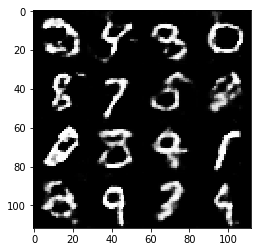

Epoch 2/2... Discriminator Loss: 1.8894... Generator Loss: 4.0331
Epoch 2/2... Discriminator Loss: 0.8840... Generator Loss: 2.1006
Epoch 2/2... Discriminator Loss: 1.1296... Generator Loss: 0.5990
Epoch 2/2... Discriminator Loss: 0.7104... Generator Loss: 1.3422
Epoch 2/2... Discriminator Loss: 1.9414... Generator Loss: 0.2928
Epoch 2/2... Discriminator Loss: 0.9404... Generator Loss: 1.4278
Epoch 2/2... Discriminator Loss: 0.8287... Generator Loss: 1.3170
Epoch 2/2... Discriminator Loss: 0.6805... Generator Loss: 1.2887
Epoch 2/2... Discriminator Loss: 0.8103... Generator Loss: 0.8804
Epoch 2/2... Discriminator Loss: 0.8026... Generator Loss: 1.0432


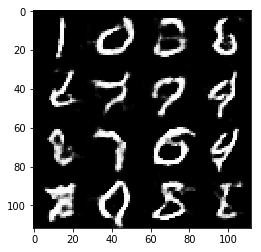

Epoch 2/2... Discriminator Loss: 1.0552... Generator Loss: 0.6086
Epoch 2/2... Discriminator Loss: 0.5887... Generator Loss: 1.8176
Epoch 2/2... Discriminator Loss: 0.7917... Generator Loss: 1.7000


In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.5730... Generator Loss: 0.5631
Epoch 1/1... Discriminator Loss: 0.6291... Generator Loss: 1.3072
Epoch 1/1... Discriminator Loss: 0.5604... Generator Loss: 1.5350
Epoch 1/1... Discriminator Loss: 0.3559... Generator Loss: 1.7832
Epoch 1/1... Discriminator Loss: 0.3152... Generator Loss: 1.9527
Epoch 1/1... Discriminator Loss: 0.2853... Generator Loss: 2.0497
Epoch 1/1... Discriminator Loss: 0.2934... Generator Loss: 2.1748
Epoch 1/1... Discriminator Loss: 0.2650... Generator Loss: 2.1681
Epoch 1/1... Discriminator Loss: 0.1993... Generator Loss: 2.5408
Epoch 1/1... Discriminator Loss: 0.2663... Generator Loss: 2.1137


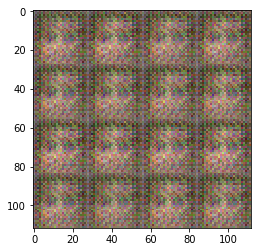

Epoch 1/1... Discriminator Loss: 0.3215... Generator Loss: 1.7795
Epoch 1/1... Discriminator Loss: 0.2596... Generator Loss: 2.1997
Epoch 1/1... Discriminator Loss: 0.2057... Generator Loss: 2.4210
Epoch 1/1... Discriminator Loss: 0.1655... Generator Loss: 2.7254
Epoch 1/1... Discriminator Loss: 0.1446... Generator Loss: 2.9653
Epoch 1/1... Discriminator Loss: 0.2191... Generator Loss: 2.2569
Epoch 1/1... Discriminator Loss: 0.2627... Generator Loss: 2.2145
Epoch 1/1... Discriminator Loss: 0.1736... Generator Loss: 2.7500
Epoch 1/1... Discriminator Loss: 0.1640... Generator Loss: 2.6831
Epoch 1/1... Discriminator Loss: 0.1181... Generator Loss: 3.9274


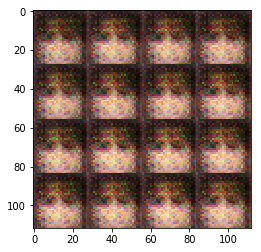

Epoch 1/1... Discriminator Loss: 0.1172... Generator Loss: 2.9576
Epoch 1/1... Discriminator Loss: 0.1841... Generator Loss: 3.4976
Epoch 1/1... Discriminator Loss: 0.1360... Generator Loss: 3.0315
Epoch 1/1... Discriminator Loss: 0.1263... Generator Loss: 2.7823
Epoch 1/1... Discriminator Loss: 0.1778... Generator Loss: 2.5338
Epoch 1/1... Discriminator Loss: 0.1056... Generator Loss: 3.9478
Epoch 1/1... Discriminator Loss: 0.1370... Generator Loss: 3.5892
Epoch 1/1... Discriminator Loss: 0.1499... Generator Loss: 3.2928
Epoch 1/1... Discriminator Loss: 0.3824... Generator Loss: 2.2306
Epoch 1/1... Discriminator Loss: 0.5465... Generator Loss: 3.3753


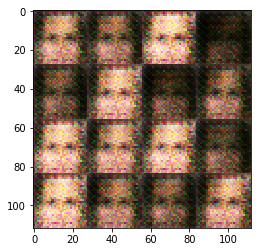

Epoch 1/1... Discriminator Loss: 0.4604... Generator Loss: 1.3784
Epoch 1/1... Discriminator Loss: 0.3443... Generator Loss: 1.9819
Epoch 1/1... Discriminator Loss: 0.3241... Generator Loss: 1.8269
Epoch 1/1... Discriminator Loss: 0.2810... Generator Loss: 1.9701
Epoch 1/1... Discriminator Loss: 0.5169... Generator Loss: 1.4580
Epoch 1/1... Discriminator Loss: 0.2431... Generator Loss: 2.0929
Epoch 1/1... Discriminator Loss: 0.2067... Generator Loss: 3.0277
Epoch 1/1... Discriminator Loss: 0.4277... Generator Loss: 1.8720
Epoch 1/1... Discriminator Loss: 0.4061... Generator Loss: 1.9474
Epoch 1/1... Discriminator Loss: 0.2526... Generator Loss: 2.7016


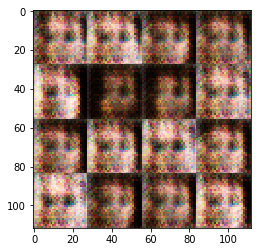

Epoch 1/1... Discriminator Loss: 0.3755... Generator Loss: 1.8714
Epoch 1/1... Discriminator Loss: 0.5283... Generator Loss: 1.4990
Epoch 1/1... Discriminator Loss: 0.3885... Generator Loss: 2.6500
Epoch 1/1... Discriminator Loss: 0.3916... Generator Loss: 1.8278
Epoch 1/1... Discriminator Loss: 0.4426... Generator Loss: 1.8036
Epoch 1/1... Discriminator Loss: 0.5148... Generator Loss: 1.9927
Epoch 1/1... Discriminator Loss: 0.6494... Generator Loss: 3.0556
Epoch 1/1... Discriminator Loss: 0.5102... Generator Loss: 2.0960
Epoch 1/1... Discriminator Loss: 1.0527... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 0.8973... Generator Loss: 1.3037


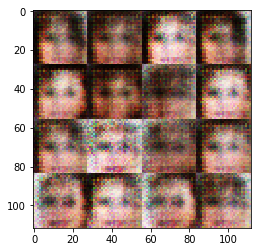

Epoch 1/1... Discriminator Loss: 0.6107... Generator Loss: 1.3624
Epoch 1/1... Discriminator Loss: 0.8307... Generator Loss: 0.9860
Epoch 1/1... Discriminator Loss: 0.7270... Generator Loss: 1.1143
Epoch 1/1... Discriminator Loss: 0.7270... Generator Loss: 1.3562
Epoch 1/1... Discriminator Loss: 0.6470... Generator Loss: 1.3808
Epoch 1/1... Discriminator Loss: 0.6165... Generator Loss: 1.6276
Epoch 1/1... Discriminator Loss: 0.8271... Generator Loss: 1.2364
Epoch 1/1... Discriminator Loss: 1.1440... Generator Loss: 2.0561
Epoch 1/1... Discriminator Loss: 0.7377... Generator Loss: 1.2238
Epoch 1/1... Discriminator Loss: 0.5491... Generator Loss: 1.7073


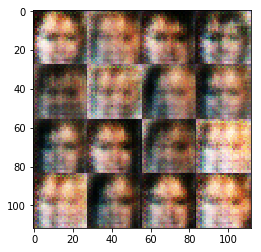

Epoch 1/1... Discriminator Loss: 0.9501... Generator Loss: 1.3083
Epoch 1/1... Discriminator Loss: 0.6205... Generator Loss: 1.5279
Epoch 1/1... Discriminator Loss: 0.5776... Generator Loss: 1.9883
Epoch 1/1... Discriminator Loss: 0.8255... Generator Loss: 1.5092
Epoch 1/1... Discriminator Loss: 0.4795... Generator Loss: 1.9455
Epoch 1/1... Discriminator Loss: 0.4994... Generator Loss: 1.9141
Epoch 1/1... Discriminator Loss: 0.7163... Generator Loss: 1.3086
Epoch 1/1... Discriminator Loss: 0.8266... Generator Loss: 1.1943
Epoch 1/1... Discriminator Loss: 0.6402... Generator Loss: 1.5603
Epoch 1/1... Discriminator Loss: 0.4531... Generator Loss: 2.2137


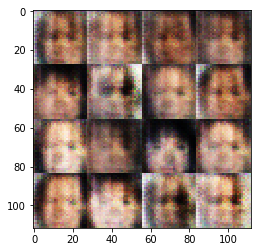

Epoch 1/1... Discriminator Loss: 0.5480... Generator Loss: 1.7111
Epoch 1/1... Discriminator Loss: 0.5430... Generator Loss: 1.8062
Epoch 1/1... Discriminator Loss: 0.4825... Generator Loss: 1.9535
Epoch 1/1... Discriminator Loss: 0.6356... Generator Loss: 1.3316
Epoch 1/1... Discriminator Loss: 0.6540... Generator Loss: 1.9953
Epoch 1/1... Discriminator Loss: 0.7737... Generator Loss: 0.9556
Epoch 1/1... Discriminator Loss: 0.5361... Generator Loss: 1.9363
Epoch 1/1... Discriminator Loss: 0.3481... Generator Loss: 2.4305
Epoch 1/1... Discriminator Loss: 0.5562... Generator Loss: 1.6574
Epoch 1/1... Discriminator Loss: 0.7372... Generator Loss: 1.9775


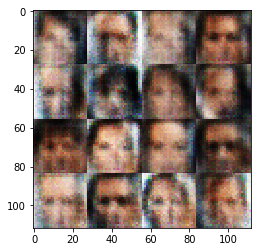

Epoch 1/1... Discriminator Loss: 0.5725... Generator Loss: 1.2625
Epoch 1/1... Discriminator Loss: 0.6960... Generator Loss: 1.4770
Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 2.3735
Epoch 1/1... Discriminator Loss: 0.6829... Generator Loss: 1.3181
Epoch 1/1... Discriminator Loss: 0.7170... Generator Loss: 1.3740
Epoch 1/1... Discriminator Loss: 0.8656... Generator Loss: 1.0135
Epoch 1/1... Discriminator Loss: 0.6298... Generator Loss: 1.6948
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 2.5900
Epoch 1/1... Discriminator Loss: 0.7965... Generator Loss: 0.9680
Epoch 1/1... Discriminator Loss: 0.7548... Generator Loss: 1.4799


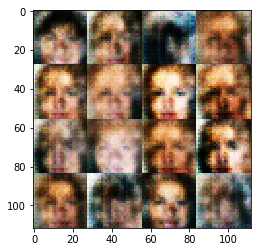

Epoch 1/1... Discriminator Loss: 0.7874... Generator Loss: 1.1683
Epoch 1/1... Discriminator Loss: 1.0375... Generator Loss: 1.9337
Epoch 1/1... Discriminator Loss: 0.6898... Generator Loss: 1.9969
Epoch 1/1... Discriminator Loss: 0.7365... Generator Loss: 1.2457
Epoch 1/1... Discriminator Loss: 0.8631... Generator Loss: 1.0662
Epoch 1/1... Discriminator Loss: 0.8739... Generator Loss: 1.6556
Epoch 1/1... Discriminator Loss: 0.8060... Generator Loss: 1.2587
Epoch 1/1... Discriminator Loss: 0.7088... Generator Loss: 1.5255
Epoch 1/1... Discriminator Loss: 0.7951... Generator Loss: 1.8574
Epoch 1/1... Discriminator Loss: 1.1668... Generator Loss: 0.5389


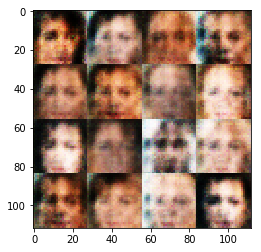

Epoch 1/1... Discriminator Loss: 1.0080... Generator Loss: 1.0792
Epoch 1/1... Discriminator Loss: 1.0475... Generator Loss: 1.0809
Epoch 1/1... Discriminator Loss: 0.9574... Generator Loss: 1.7093
Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 0.7958... Generator Loss: 1.3603
Epoch 1/1... Discriminator Loss: 1.0623... Generator Loss: 1.1864
Epoch 1/1... Discriminator Loss: 0.7532... Generator Loss: 1.2709
Epoch 1/1... Discriminator Loss: 0.9167... Generator Loss: 1.3327
Epoch 1/1... Discriminator Loss: 0.7711... Generator Loss: 1.0817
Epoch 1/1... Discriminator Loss: 0.7810... Generator Loss: 1.2140


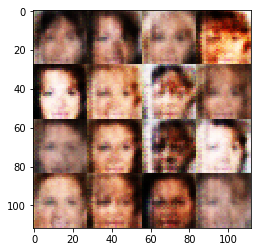

Epoch 1/1... Discriminator Loss: 1.1191... Generator Loss: 2.2426
Epoch 1/1... Discriminator Loss: 0.7008... Generator Loss: 1.4376
Epoch 1/1... Discriminator Loss: 0.8348... Generator Loss: 1.5014
Epoch 1/1... Discriminator Loss: 0.9904... Generator Loss: 0.8585
Epoch 1/1... Discriminator Loss: 0.9732... Generator Loss: 2.2369
Epoch 1/1... Discriminator Loss: 0.8387... Generator Loss: 1.4927
Epoch 1/1... Discriminator Loss: 1.0498... Generator Loss: 1.5350
Epoch 1/1... Discriminator Loss: 0.8405... Generator Loss: 1.4555
Epoch 1/1... Discriminator Loss: 0.8329... Generator Loss: 1.2640
Epoch 1/1... Discriminator Loss: 0.7355... Generator Loss: 1.2592


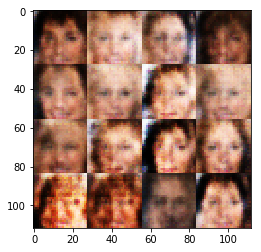

Epoch 1/1... Discriminator Loss: 0.7862... Generator Loss: 1.1231
Epoch 1/1... Discriminator Loss: 0.8541... Generator Loss: 1.0252
Epoch 1/1... Discriminator Loss: 0.8178... Generator Loss: 1.3571
Epoch 1/1... Discriminator Loss: 0.8533... Generator Loss: 0.9678
Epoch 1/1... Discriminator Loss: 0.7510... Generator Loss: 1.3956
Epoch 1/1... Discriminator Loss: 0.7493... Generator Loss: 1.3857
Epoch 1/1... Discriminator Loss: 0.9469... Generator Loss: 1.0806
Epoch 1/1... Discriminator Loss: 0.9060... Generator Loss: 1.2092
Epoch 1/1... Discriminator Loss: 0.8133... Generator Loss: 1.2028
Epoch 1/1... Discriminator Loss: 0.8098... Generator Loss: 1.0537


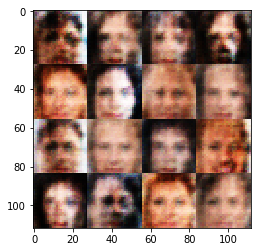

Epoch 1/1... Discriminator Loss: 0.8148... Generator Loss: 1.6974
Epoch 1/1... Discriminator Loss: 0.7951... Generator Loss: 1.3430
Epoch 1/1... Discriminator Loss: 0.7275... Generator Loss: 1.2318
Epoch 1/1... Discriminator Loss: 0.8721... Generator Loss: 1.5820
Epoch 1/1... Discriminator Loss: 0.7516... Generator Loss: 1.6787
Epoch 1/1... Discriminator Loss: 0.9723... Generator Loss: 1.9755
Epoch 1/1... Discriminator Loss: 0.6192... Generator Loss: 1.4501
Epoch 1/1... Discriminator Loss: 0.9365... Generator Loss: 1.5534
Epoch 1/1... Discriminator Loss: 0.9192... Generator Loss: 1.5271
Epoch 1/1... Discriminator Loss: 0.9516... Generator Loss: 0.9440


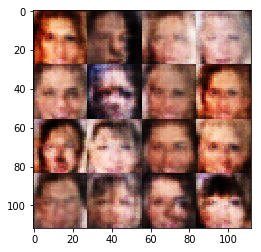

Epoch 1/1... Discriminator Loss: 1.0524... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 0.6958... Generator Loss: 1.4223
Epoch 1/1... Discriminator Loss: 0.8634... Generator Loss: 0.8888
Epoch 1/1... Discriminator Loss: 0.9167... Generator Loss: 1.0775
Epoch 1/1... Discriminator Loss: 0.7380... Generator Loss: 1.3473
Epoch 1/1... Discriminator Loss: 0.9026... Generator Loss: 1.1437
Epoch 1/1... Discriminator Loss: 0.8245... Generator Loss: 1.1993
Epoch 1/1... Discriminator Loss: 0.9634... Generator Loss: 0.9604
Epoch 1/1... Discriminator Loss: 1.0880... Generator Loss: 1.1063
Epoch 1/1... Discriminator Loss: 0.9599... Generator Loss: 1.1326


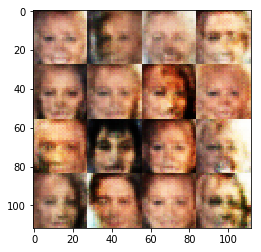

Epoch 1/1... Discriminator Loss: 0.8288... Generator Loss: 0.9916
Epoch 1/1... Discriminator Loss: 0.8347... Generator Loss: 1.5161
Epoch 1/1... Discriminator Loss: 0.7633... Generator Loss: 1.1145
Epoch 1/1... Discriminator Loss: 0.7307... Generator Loss: 1.3942
Epoch 1/1... Discriminator Loss: 0.7668... Generator Loss: 1.3975
Epoch 1/1... Discriminator Loss: 0.9450... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 0.7634... Generator Loss: 1.5987
Epoch 1/1... Discriminator Loss: 0.8997... Generator Loss: 1.4943


In [15]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.